# Isotropic and orthotropic plane stress elasticity {far}`star`

```{admonition} Objectives
:class: objectives

This demo shows how to define a linear elastic problem with an isotropic and orthotropic material in plane stress conditions. It also shows how to use the `Gmsh` Python API to define a 2D perforated plate domain.
$\newcommand{\bsig}{\boldsymbol{\sigma}}
\newcommand{\beps}{\boldsymbol{\varepsilon}}
\newcommand{\bu}{\boldsymbol{u}}
\newcommand{\bv}{\boldsymbol{v}}
\newcommand{\bT}{\boldsymbol{T}}
\newcommand{\bI}{\boldsymbol{I}}
\newcommand{\T}{^\text{T}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\CC}{\mathbb{C}}
\newcommand{\dOm}{\,\text{d}\Omega}
\newcommand{\dS}{\,\text{d}S}
\newcommand{\Neumann}{{\partial \Omega_\text{N}}}
\newcommand{\Dirichlet}{{\partial \Omega_\text{D}}}$
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./isotropic_orthotropic_elasticity.py>`
* {Download}`Jupyter notebook<./isotropic_orthotropic_elasticity.ipynb>`
```

```{seealso}
The [Linear Elasticity introduction tour](/intro/linear_elasticity/linear_elasticity) covers a very similar topic. We refer the reader to this tour for more details on some aspect of the `FEniCSx` implementation which will be only briefly recalled here (e.g. UFL operators, boundary conditions, etc.).
```

## Variational formulation

We first recall that the variational formulation associated to the linear elastic case reads:

Find $\bu \in V$ such that:

$$
\int_\Omega \nabla^\text{s}\bu:\CC:\nabla^\text{s} \bv \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS \quad \forall \bv \in V_0
$$

where $\bv$ is the test function, $\boldsymbol{f}$ the body and $\bT$ the contact forces. $\CC$ is the fourth-order elastic tensor characterizing the linear elastic behavior. Introducing the linearized strain tensor field $\beps[\bu] = \nabla^\text{s} \bu = \dfrac{1}{2}(\nabla \bu + \nabla\bu)$, it relates the stress $\bsig$ to the strain $\beps$ using the linear elastic constitutive relation:
\begin{equation*}
\bsig = \CC:\beps
\end{equation*}

The above variational formulation can therefore be rewritten as:
Find $\bu \in V$ such that:
```{math}
:label: weak-form

\int_\Omega \bsig[\bu]:\beps[\bv] \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS \quad \forall \bv \in V_0
```

The above problem is a linear variational problem since $\bsig$ depends linearly upon the unknown field $\bu$. It can be formally written as:

```{math}
:label: bilinear

a(\bu,\bv)=L(\bv) \quad \forall \bv \in V_0
```


```{tip}
In some cases, one may want to consider a non-zero initial stress state $\bsig_0$ associated with the reference undeformed configuration. In this case, the stress/strain relation is written as:
\begin{equation*}
\bsig = \bsig_0 + \CC:\beps
\end{equation*}

The constant part $\bsig_0$ will therefore contribute to the right-hand side of the linear variational problem {eq}`bilinear` which now becomes:

$$
\int_\Omega \beps[\bu]:\CC:\beps[\bv] \dOm = \int_\Omega \boldsymbol{f}\cdot\bv \dOm + \int_\Neumann \bT\cdot\bv \dS -\int_\Omega \bsig_0:\beps[\bv] \dOm \quad \forall \bv \in V_0
$$
```

### Constitutive relation

In practice for a concrete implementation, the formal stress/strain relation  $\bsig = \CC:\beps$ can be defined either using intrinsic tensorial or using instead engineering (vectorial) notation. For instance, the isotropic linear elastic case reads in tensorial notation:
```{math}
:label: isotropic
\bsig = \lambda \tr(\beps)\bI + 2\mu\beps
```
in 3D and 2D plane strain conditions. The relation can also be inverted as follows:
```{math}
:label: isotropic-compliance
\beps = -\dfrac{\nu}{E} \tr(\bsig)\bI + \dfrac{1+\nu}{E}\bsig
```


On the other hand, the engineering notation represents the tensor as a list of its Cartesian components using either the Voigt convention:
\begin{align*}
\{\varepsilon\} &= \begin{Bmatrix} \varepsilon_{xx} & \varepsilon_{yy} & 2\varepsilon_{xy} \end{Bmatrix}\T \tag{Voigt}\\
\{\sigma\} &= \begin{Bmatrix} \sigma_{xx} & \sigma_{yy} & \sigma_{xy} \end{Bmatrix}\T\\
\end{align*}
or the Mandel (or Kelvin) convention:
\begin{align*}
\{\varepsilon\} &= \begin{Bmatrix} \varepsilon_{xx} & \varepsilon_{yy} & \sqrt{2}\varepsilon_{xy} \end{Bmatrix}\T \tag{Mandel}\\
\{\sigma\} &= \begin{Bmatrix} \sigma_{xx} & \sigma_{yy} & \sqrt{2}\sigma_{xy} \end{Bmatrix}\T\\
\end{align*}
In both cases, the $2$ or $\sqrt{2}$ in front of the shear components is introduced so that, in both cases, the vectorial dot product equals to the tensorial inner product:
\begin{equation*}
\{\sigma\}\T\cdot\{\varepsilon\} = \bsig:\beps = \sigma_{ij}\varepsilon_{ij}
\end{equation*}

```{tip}
The presence of a factor 2 in strain-like quantities and its absence in stress-like quantities can be the source of numerous mistakes. We suggest to use the safer Mandel representation which is a one-to-one mapping between a symmetric second-rank tensor and its vectorial representation, irrespectively of the nature of the underlying physical quantity. Besides, the Mandel notation preserves the norm of the corresponding tensor.
```

In such a vectorial representation, the constitutive equation reads:
\begin{equation*}
\{\sigma\} = [\mathbf{C}]\{\varepsilon\}
\end{equation*}

where $[\mathbf{C}]$ is the 3x3 elastic stiffness matrix given by:
\begin{align*}
[\mathbf{C}] &= \begin{bmatrix}
C_{xxxx} & C_{xxyy} & C_{xxxy} \\
C_{yyxx} & C_{yyyy} & C_{yyxy} \\
C_{xxxy} & C_{yyxy} & C_{xyxy}
\end{bmatrix} \quad \text{for Voigt}\\
[\mathbf{C}] &= \begin{bmatrix}
C_{xxxx} & C_{xxyy} & \sqrt{2}C_{xxxy} \\
C_{yyxx} & C_{yyyy} & \sqrt{2}C_{yyxy} \\
\sqrt{2}C_{xxxy} & \sqrt{2}C_{yyxy} & 2C_{xyxy}
\end{bmatrix} \quad \text{for Mandel}
\end{align*}

Despite our previous suggestion, we will use the **Voigt notation** in the remainder of this demo to conform to the common practice. We implement the `strain` function providing either the tensorial representation of the strain or the corresponding vectorial representation associated with a generic displacement field $\bu$:
\begin{align*}
\varepsilon_{xx} &= \dfrac{\partial u_x}{\partial x}\\
\varepsilon_{yy} &= \dfrac{\partial u_y}{\partial y}\\
2\varepsilon_{xy} &= \dfrac{\partial u_x}{\partial y}+ \dfrac{\partial u_y}{\partial x}\\\\
\end{align*}

In [1]:
import ufl


def strain(u, repr="vectorial"):
    eps_t = ufl.sym(ufl.grad(u))
    if repr == "vectorial":
        return ufl.as_vector([eps_t[0, 0], eps_t[1, 1], 2 * eps_t[0, 1]])
    elif repr == "tensorial":
        return eps_t

#### Isotropic plane strain case
In the isotropic case the elastic stiffness matrix associated with {eq}`isotropic` becomes:
\begin{equation*}
[\mathbf{C}] = \begin{bmatrix}
\lambda + 2\mu & \lambda & 0 \\
\lambda & \lambda+2\mu & 0 \\
0 & 0 & \mu
\end{bmatrix}
\end{equation*}

#### Isotropic plane stress case
In the plane stress case, an out-of-plane strain component $\varepsilon_{zz}$ must be considered so that $\sigma_{zz}=0$. Using this condition in the 3D constitutive relation {eq}`isotropic-compliance`, one has $\varepsilon_{zz}=-\frac{\nu}{E}(\sigma_{xx}+\sigma_{yy})$. The resulting plane-stress compliance matrix therefore reads:
```{math}
:label: compliance-plane-stress

[\mathbf{S}] = \begin{bmatrix} 1/E & -\nu/E & 0\\
   -\nu/E & 1/E & 0 \\ 0 & 0 & 1/\mu \end{bmatrix}
```
This relation needs to be inverted to obtain the corresponding stiffness matrix $\mathbf{C}=\mathbf{S}^{-1}$:

$$
[\mathbf{C}] = \dfrac{E}{1-\nu^2}\begin{bmatrix} 1 & \nu & 0\\
   \nu & 1 & 0 \\ 0 & 0 & (1-\nu)/2 \end{bmatrix}
$$

If using a tensorial notation, simple computations show that the 2D plane-stress constitutive equation reads:

```{math}
:label: isotropic-plane-stress
\bsig = \lambda^* \tr(\beps)\bI + 2\mu\beps
```

that is as {eq}`isotropic` except that we are using a modified value of the Lamé coefficient:

$$
\lambda^* = \dfrac{2\lambda\mu}{\lambda+2\mu} = \dfrac{E\nu}{1-\nu^2}
$$

#### Orthotropic plane stress case

In the plane-stress orthotropic case, we assume that the 2D material possesses 2 planes of symmetry corresponding to the global $x$ and $y$ directions. Adapting the plane-stress compliance matrix {eq}`compliance-plane-stress` to the orthotropic case yields:
```{math}
:label: compliance-plane-stress-orthotropic

[\mathbf{S}] = \begin{bmatrix} 1/E_x & -\nu_{xy}/E_x & 0\\
   -\nu_{yx}/E_y & 1/E_y & 0 \\ 0 & 0 & 1/G_{xy} \end{bmatrix}
```
with $E_x, E_y$ being the two Young's moduli in the orthotropy directions, $\nu_{xy}$ the in-plane Poisson ration (with the following relation ensuring the constitutive relation symmetry $\nu_{yx}=\nu_{xy}E_y/E_x$) and $G_{xy}$ being the shear modulus. Again, this relation needs to be inverted to obtain the stiffness matrix.

In [2]:
Ex, Ey, nuxy, Gxy = 10.0, 20.0, 0.3, 5.0
S = ufl.as_matrix(
    [[1.0 / Ex, -nuxy / Ex, 0.0], [-nuxy / Ex, 1.0 / Ey, 0.0], [0.0, 0.0, 1.0 / Gxy]]
)
C = ufl.inv(S)

```{note}
Here we used the `ufl.inv` operator to compute the stiffness matrix $\mathbf{C}$. We could also have computed analytically the inverse relation. Note that the `inv` operator is implemented only up to 3x3 matrices. Extension to the 3D case yields 6x6 matrices and therefore requires either analytical inversion or numerical inversion using `Numpy` for instance (assuming that the material parameters are constants).
```

```{attention}
If the material frame is not coincident with the global $x$,$y$ directions, the above expression should be understood with respect to the material frame. The stiffness matrix must then be brought back from the material frame to the global frame as $[\mathbf{T}]\T[\mathbf{C}][\mathbf{T}]$ using a transformation matrix $[\mathbf{T}]$.
```

Finally, we can define the stress function `stress`, again using either a vectorial or a tensorial representation, as:

In [3]:
def stress(u, repr="vectorial"):
    sigv = ufl.dot(C, strain(u))
    if repr == "vectorial":
        return sigv
    elif repr == "tensorial":
        return ufl.as_matrix([[sigv[0], sigv[2]], [sigv[2], sigv[1]]])

With such representations the expressions `ufl.dot(stress(u, "vectorial"), strain(u, "vectorial"))` and `ufl.dot(stress(u, "tensorial"), strain(u, "tensorial"))` are identical.

## Problem implementation

### Geometry and mesh generation using `Gmsh` API

We now consider the case of a square plate perforated by a circular hole of radius $R$, the plate dimension is $2L\times 2L$ with $L \gg R$. Loading will consists of a uniform isotropic traction on all boundaries. However, only the top-right quarter of the plate will be considered using appropriate symmetry boundary conditions. We use here the `gmsh` Python API with the Open-Cascade (`occ`) kernel to easily define the problem geometry. Creating entities using constructive solid geometry is very useful for building complex geometry but can lead to difficulties when identifying the resulting object boundaries. Here we use the `getEntitiesInBoundingBox` to identify the corresponding boundaries. Finally, we also set a global mesh size `h`.

In [4]:
from mpi4py import MPI
import gmsh
from dolfinx.io.gmshio import model_to_mesh

L, R = 1.0, 0.1
h = 0.02

gdim = 2  # domain geometry dimension
fdim = 1  # facets dimension

gmsh.initialize()

occ = gmsh.model.occ
mesh_comm = MPI.COMM_WORLD
model_rank = 0
if mesh_comm.rank == model_rank:
    plate = occ.addRectangle(0.0, 0.0, 0.0, L, L)  # (x, y, z, dx, dy)
    notch = occ.addDisk(0.0, 0.0, 0.0, R, R)  # (x, y, z, Rx, Ry=Rx)

    # cut "plate" with "notch"
    outDimTags, _ = occ.cut([(gdim, plate)], [(gdim, notch)])
    # get tag of newly created object
    perf_plate = outDimTags[0][1]

    occ.synchronize()

    # identify boundary tags from bounding box
    eps = 1e-3  # tolerance for bounding box
    left = gmsh.model.getEntitiesInBoundingBox(
        -eps, -eps, -eps, eps, L + eps, eps, dim=fdim
    )[0][1]
    bottom = gmsh.model.getEntitiesInBoundingBox(
        -eps, -eps, -eps, L + eps, eps, eps, dim=fdim
    )[0][1]
    right = gmsh.model.getEntitiesInBoundingBox(
        L - eps, -eps, -eps, L + eps, L + eps, eps, dim=fdim
    )[0][1]
    top = gmsh.model.getEntitiesInBoundingBox(
        -eps, L - eps, -eps, L + eps, L + eps, eps, dim=fdim
    )[0][1]
    # tag physical domains and facets
    gmsh.model.addPhysicalGroup(gdim, [perf_plate], 1)
    gmsh.model.addPhysicalGroup(fdim, [bottom], 1)
    gmsh.model.addPhysicalGroup(fdim, [right], 2)
    gmsh.model.addPhysicalGroup(fdim, [top], 3)
    gmsh.model.addPhysicalGroup(fdim, [left], 4)

    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", h)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h)

    gmsh.model.mesh.generate(gdim)

    domain, cells, facets = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 60%] Meshing curve 4 (Line)
Info    : [ 80%] Meshing curve 5 (Line)
Info    : Done meshing 1D (Wall 0.00104915s, CPU 0.000698s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0964789s, CPU 0.094692s)
Info    : 3010 nodes 6023 elements


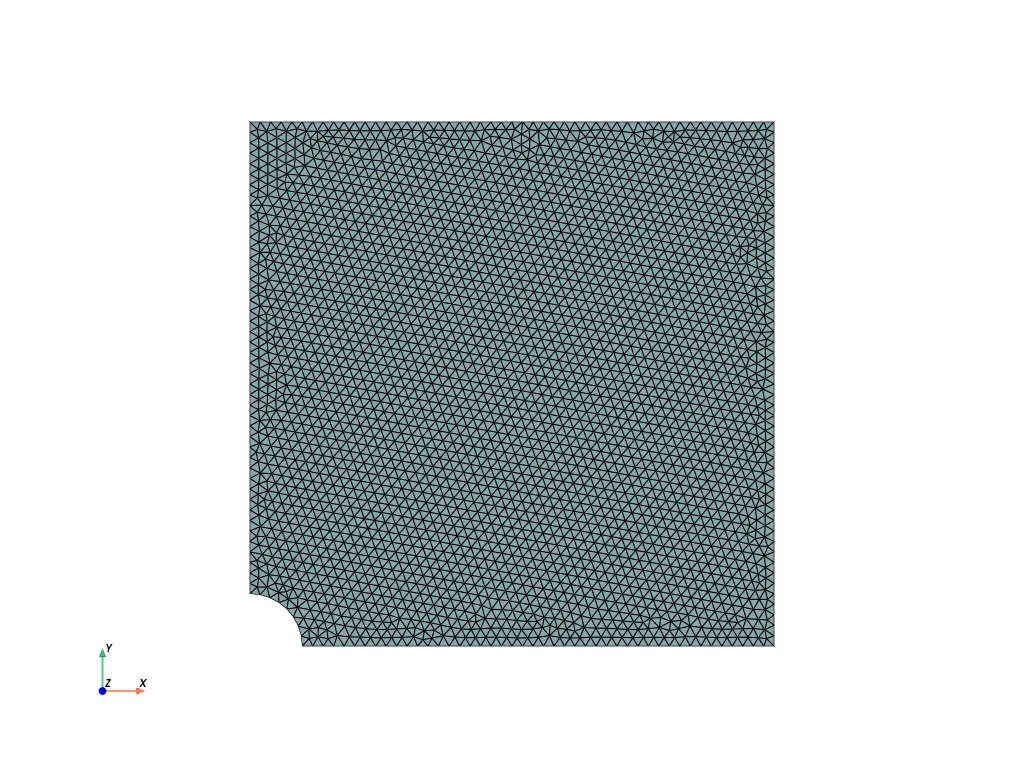

In [5]:
import pyvista
from dolfinx import plot, fem

pyvista.set_jupyter_backend("static")

topology, cell_types, geometry = plot.vtk_mesh(domain, gdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Create plotter and pyvista grid
p = pyvista.Plotter()
p.add_mesh(grid, show_edges=True)
p.view_xy()
p.show_axes()
p.show()

We are now in position to define the variational form which is given by {eq}`weak-form`,
the linear form now contains a Neumann term corresponding to a uniform vertical traction $T$ on the right and top boundaries (tag `2` and `3` respectively). On boundaries `1` and `4`, we respectively impose symmetry boundary conditions: $u_y=0$ and $u_x=0$.

In [6]:
from dolfinx import fem, io
import dolfinx.fem.petsc

# Define function space
V = fem.functionspace(domain, ("P", 2, (gdim,)))

# Define variational problem
du = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")
a_form = ufl.inner(stress(du), strain(u_)) * ufl.dx

# uniform traction on top boundary
ds = ufl.Measure("ds", domain=domain, subdomain_data=facets)
T = fem.Constant(domain, 10.0)
n = ufl.FacetNormal(domain)
L_form = ufl.dot(T * n, u_) * ds((2, 3))

V_ux, _ = V.sub(0).collapse()
V_uy, _ = V.sub(1).collapse()
bottom_dofs = fem.locate_dofs_topological((V.sub(1), V_uy), fdim, facets.find(1))
left_dofs = fem.locate_dofs_topological((V.sub(0), V_ux), fdim, facets.find(4))

ux0 = fem.Function(V_ux)
uy0 = fem.Function(V_uy)
bcs = [
    fem.dirichletbc(ux0, left_dofs, V.sub(0)),
    fem.dirichletbc(uy0, bottom_dofs, V.sub(1)),
]


problem = fem.petsc.LinearProblem(a_form, L_form, u=u, bcs=bcs)
problem.solve()


V0 = fem.functionspace(domain, ("DG", 0, (3,)))
sig_exp = fem.Expression(stress(u), V0.element.interpolation_points())
sig = fem.Function(V0, name="Stress")
sig.interpolate(sig_exp)

vtk = io.VTKFile(domain.comm, "linear_elasticity.pvd", "w")
vtk.write_function(u, 0)
vtk.write_function(sig, 0)
vtk.close()

```{image} orthotropic_elasticity.png
:alt: Results
:class: bg-primary mb-1
:width: 1000px
:align: center
```